In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string


In [107]:
df = pd.read_csv('https://raw.githubusercontent.com/MicaelaER/Data-Science-III---Coder-House/refs/heads/main/Reviews%20from%20Amazon.csv')

In [108]:
## Preprocesado

sentiments = df['sentiments']
class_names = list(set(sentiments))
class_names

['negative', 'positive', 'neutral']

In [109]:
df['labels'] = [class_names.index(sentiment) for sentiment in list(sentiments)]

In [110]:
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score,labels
0,positive,i wish would have gotten one earlier love it a...,19,5.0,1
1,neutral,i ve learned this lesson again open the packag...,88,1.0,2
2,neutral,it is so slow and lags find better option,9,2.0,2
3,neutral,roller ball stopped working within months of m...,12,1.0,2
4,neutral,i like the color and size but it few days out ...,21,1.0,2


In [111]:
dataset = df.drop(columns=['sentiments'])
dataset.head()

,cleaned_review,cleaned_review_length,review_score,labels
0,i wish would have gotten one earlier love it a...,19,5.0,1
1,i ve learned this lesson again open the packag...,88,1.0,2
2,it is so slow and lags find better option,9,2.0,2
3,roller ball stopped working within months of m...,12,1.0,2
4,i like the color and size but it few days out ...,21,1.0,2


División para entrenamiento:

In [112]:
dataset.shape

(17340, 4)

In [113]:
train, val, test = np.split(dataset.sample(frac=1), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

c:\Users\bjdua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [114]:
train.head()

,cleaned_review,cleaned_review_length,review_score,labels
15880,the style is nice and the sound quality is great,10,5.0,1
7318,great product so far cool lights also not batt...,14,1.0,1
1862,does right after charging didn quite work righ...,44,1.0,1
10209,by far my favorite headset,5,1.0,2
4696,broke did not work,4,2.0,2


In [115]:
val.head()

,cleaned_review,cleaned_review_length,review_score,labels
4566,this mouse is much faster than my last few lik...,31,2.0,2
6134,i purchased this with the hope to use it for m...,57,3.0,1
4749,i have never used it because everything is in ...,15,5.0,2
10434,i bought these maybe couple months ago they we...,35,5.0,2
13569,my boys use it for school they have encountere...,11,5.0,2


In [116]:
test.head()

,cleaned_review,cleaned_review_length,review_score,labels
3805,i loved this but ve only had it two months and...,14,1.0,2
13333,this is terrible product and we have been thro...,21,5.0,2
14754,truly impressive sound and battery life bought...,32,4.0,1
7523,i am just past the return window and of course...,22,2.0,2
13299,i am casual gamer this seems to be good produc...,13,5.0,1


In [117]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    text = list(dataframe['cleaned_review'])
    labels = list(dataframe['labels'])
    ds = tf.data.Dataset.from_tensor_slices((np.array(text), np.array(labels)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).prefetch(batch_size)
    return ds
    

In [118]:
raw_train_ds = df_to_dataset(train)
raw_val_ds = df_to_dataset(val)
raw_test_ds = df_to_dataset(test)

In [119]:
[(train_texts, train_labels)] = raw_train_ds.take(1)

In [120]:
print(train_texts[0].numpy())
print("="*100)
print(class_names[train_labels[0].numpy()])

b'loved this mouse but it breaks super easily liked it and figured give it another chance so bought second one and it broke after months it soft to the touch and very quiet which liked unfortunately both times the scroll button stopped working feels like it detaches you get what you pay for '
positive


Vectorización

In [121]:
def standardization(input_text):
    text = tf.strings.lower(input_text)
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')
    return text

In [122]:
vocab_size = 10000
sequence_length = 50
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [123]:
train_texts = raw_train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_texts)

In [124]:
text_batch, label_batch = next(iter(raw_train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("Review", first_text)
print("="*120)
print("Label", first_label)
print("="*120)
print("Vectorized review\n", vectorize_layer(first_text))

Review tf.Tensor(b'buttons stick would not buy', shape=(), dtype=string)
Label tf.Tensor(2, shape=(), dtype=int64)
Vectorized review
 tf.Tensor(
[ 427 1105   43   12   90    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [125]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [126]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [127]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Modelo y Entrenamiento:

In [128]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [129]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [130]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5481 - loss: 0.9366 - val_accuracy: 0.5848 - val_loss: 0.8250
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6179 - loss: 0.8207 - val_accuracy: 0.6938 - val_loss: 0.7458
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6978 - loss: 0.7341 - val_accuracy: 0.7347 - val_loss: 0.6788
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7392 - loss: 0.6644 - val_accuracy: 0.7532 - val_loss: 0.6353
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7613 - loss: 0.6178 - val_accuracy: 0.7595 - val_loss: 0.6076
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7783 - loss: 0.5814 - val_accuracy: 0.7636 - val_loss: 0.5864
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.5504 - val_accuracy: 0.7768 - val_loss: 0.5672
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8007 - loss: 0.5284 - val_accuracy: 0.

Resultados, evaluación y Predicciones:

In [131]:
history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.562716,0.889382,0.584775,0.824963
1,0.639201,0.796232,0.693772,0.745753
2,0.711433,0.712699,0.734717,0.678772
3,0.743728,0.648684,0.753172,0.635328
4,0.762687,0.605743,0.759516,0.607597


<Axes: >

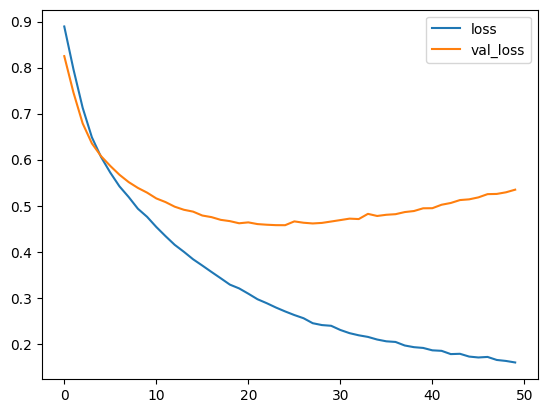

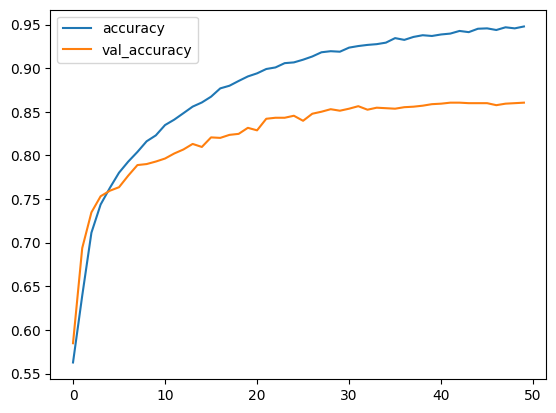

In [132]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [133]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.8545 - loss: 0.5093
Loss:  0.49722251296043396
Accuracy:  0.8725489974021912


In [134]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation("softmax")
])
model.summary()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 16)         │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,203 (1.83 MB)

 Trainable params: 160,067 (625.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,136 (1.22 MB)

In [135]:
test_text = raw_test_ds.map(lambda text, label: text)
test_label = export_model.predict(test_text)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [136]:
new_reviews = [
    "not recommended",
    "Great"
]

predictions = export_model.predict(tf.constant(new_reviews))

for review, probs in zip(new_reviews, predictions):
    pred_idx = np.argmax(probs)
    pred_class = class_names[pred_idx]
    confidence = probs[pred_idx]
    print(f'Review: \"{review}\" → {pred_class} ({confidence:.2%})')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Review: "not recommended" → neutral (85.71%)
Review: "Great" → positive (90.44%)
